In [42]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime

from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob

In [43]:
ds_allpr = xr.open_dataset('ds_pr_t_td_cape_EMCC.nc')

# LOGISTIC REGRESSION

# SELECT LEAD TIMES

Looking at week 1

In [44]:
#week 1
week1lr_all = ds_allpr.sel(L=slice(1.5,7.5)) 
#I drop the first value, L=0.5, 
#I stack only M and lat and lon
week1lr_all = week1lr_all.stack(Mll=('M','lat','lon')).compute()
week1lr_all = week1lr_all.rename({'APCP_P1_L1_GLL0':'pr','TMP_P1_L103_GLL0':'tas', 
                'DPT_P1_L103_GLL0':'tdps','CAPE_P1_2L108_GLL0':'cape'})
week1lr_all

/local/ERAin/lib/python3.6/site-packages/xarray/core/dataset.py:2648: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  v.labels,


<xarray.Dataset>
Dimensions:  (L: 7, Mll: 1694, S: 237)
Coordinates:
  * L        (L) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
Data variables:
    pr       (S, L, Mll) float32 0.0 0.0 0.1 ... 0.79999995 0.59999996
    tas      (S, L, Mll) float32 295.7 295.2 296.0 ... 299.69998 299.88 299.63
    tdps     (S, L, Mll) float32 278.1 281.0 283.4 ... 292.93 293.15 292.58
    cape     (S, L, Mll) float32 76.0 507.0 528.0 624.0 ... 176.0 221.0 195.0

In [45]:
# I average along L, it means that i am using the average value for week1
week1lr = week1lr_all.mean(dim='L')
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 237)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
Data variables:
    pr       (S, Mll) float32 2.6285713 0.90000004 ... 0.47142857 0.12857142
    tas      (S, Mll) float32 295.0 295.32858 296.80002 ... 301.36285 300.89572
    tdps     (S, Mll) float32 276.97144 277.64285 ... 292.5957 291.56143
    cape     (S, Mll) float32 150.42857 337.57144 480.2857 ... 332.0 211.14285

# Here I calculate the (first) target time for each weekly average. 
# I add the 12 hour to match the 0.5 (12hr) and then 24hr Lead times I think the lead times are organized.


# to be honest i don't recall why I made this choice. We can change the value, it wouldn't change the results a lot, since the whole vector T would translate of the same amount (I think)

In [46]:
# here I calculate T, in the case of week 1 the first T values is S+1.5
week1lr.coords['T']= (('S'), week1lr['S'].values+np.timedelta64(1,'D')+np.timedelta64(12,'h'))

# Note how I created the coordinate T as a function of S, this will allow me to swap between T and S.
# week1lr
# in the case of week 2 the first value of T is S+8
# week1lr.coords['T']=week1lr['S'].values+np.timedelta64(8,'D')+np.timedelta64(12,'h')
week1lr


<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 237)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    T        (S) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    pr       (S, Mll) float32 2.6285713 0.90000004 ... 0.47142857 0.12857142
    tas      (S, Mll) float32 295.0 295.32858 296.80002 ... 301.36285 300.89572
    tdps     (S, Mll) float32 276.97144 277.64285 ... 292.5957 291.56143
    cape     (S, Mll) float32 150.42857 337.57144 480.2857 ... 332.0 211.14285

# GET NARR

## I select the weekly averages from NARR for the same period.


In [47]:
import netCDF4
ds_Y =[]
for iy in np.arange(1999, 2017):
    print( iy)
    url = ('http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/('+
           np.str(iy)+
          ')/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/')
    print(url)
    ds_temp = xr.open_dataset(url+'dods')
    ds_Y.append(ds_temp)
    del ds_temp
    
ds_NARRpr = xr.concat(ds_Y, dim='time')

1999
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(1999)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2000
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2000)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2001
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2001)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2002
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/time/(2002)/VALUES/time/(0000%201%20Jun)/(0000%2011%20Oct)/RANGE/lat/32/42/RANGE/lon/257/270/RANGE/time/1/boxAverage/time/7/runningAverage/
2003
http://iridl.ldeo.columbia.edu/expert/home/.clepore/.NARR_ESRL_3hr_CONUS_1x1/.apcp/

In [48]:
ds_NARRpr

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 14, time: 2268)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * time     (time) datetime64[ns] 1999-06-04T12:00:00 ... 2016-10-07T12:00:00
Data variables:
    apcp     (time, lat, lon) float32 0.029748198 0.17702778 ... 0.32929924
Attributes:
    Conventions:  IRIDL

## INGRID gives the center of the week as time index - so the first value (1-8) has date 4.5.
## I will fix that to match my time index.

## This needs to be done similarly for week2 when the range of L is for 8-14.


In [49]:
ds_NARRpr.coords['time'] = ds_NARRpr.time-np.timedelta64(3,'D')

# I then select the weeks that correspond to week1 forecasts.

In [50]:
ds_NARRpr_T = ds_NARRpr.sel(time=week1lr["T"])
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (S: 237, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    time     (S) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
    T        (S) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    apcp     (S, lat, lon) float32 0.037341055 0.17766069 ... 0.39427418
Attributes:
    Conventions:  IRIDL

Because of the selection of the dates, now in the coordinates i have a few time coordinates:
    - time is == T and it is now a function of (S) because T(S)
    - I have S and T(S) that come from week1lr
    
To make it look like my forecast data, I will drop time

In [51]:
ds_NARRpr_T = ds_NARRpr_T.drop('time')

# However, the results I have are a function of the target time (or period, in this case a week, which I indexed with the first day of the week). 

# So I will swap dimension so that my data are all a function of T and Mll

In [52]:
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, S: 237)
Coordinates:
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    T        (S) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    pr       (S, Mll) float32 2.6285713 0.90000004 ... 0.47142857 0.12857142
    tas      (S, Mll) float32 295.0 295.32858 296.80002 ... 301.36285 300.89572
    tdps     (S, Mll) float32 276.97144 277.64285 ... 292.5957 291.56143
    cape     (S, Mll) float32 150.42857 337.57144 480.2857 ... 332.0 211.14285

In [53]:
week1lr = week1lr.swap_dims({'S':'T'})
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, T: 237)
Coordinates:
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * T        (T) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    pr       (T, Mll) float32 2.6285713 0.90000004 ... 0.47142857 0.12857142
    tas      (T, Mll) float32 295.0 295.32858 296.80002 ... 301.36285 300.89572
    tdps     (T, Mll) float32 276.97144 277.64285 ... 292.5957 291.56143
    cape     (T, Mll) float32 150.42857 337.57144 480.2857 ... 332.0 211.14285

In [54]:
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (S: 237, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * S        (S) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
    T        (S) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    apcp     (S, lat, lon) float32 0.037341055 0.17766069 ... 0.39427418
Attributes:
    Conventions:  IRIDL

In [55]:
ds_NARRpr_T = ds_NARRpr_T.swap_dims({'S':'T'})
ds_NARRpr_T


<xarray.Dataset>
Dimensions:  (T: 237, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * T        (T) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    apcp     (T, lat, lon) float32 0.037341055 0.17766069 ... 0.39427418
Attributes:
    Conventions:  IRIDL

(0.05, 0.45)

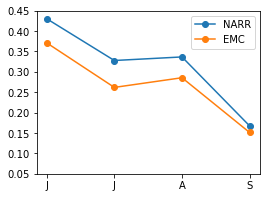

In [56]:
#quick compariosn for monthly averages
fig = plt.figure(figsize=(4,3))
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']).groupby('T.month').mean(),'-o')
plt.plot(week1lr.mean(dim='Mll').pr.groupby('T.month').mean()/8,'-o') 
plt.legend(('NARR','EMC'))
plt.xticks((0,1,2,3),('J','J','A','S'))
plt.ylim((0.05,0.45))

Text(0.9, 0.9, 'corr=0.8')

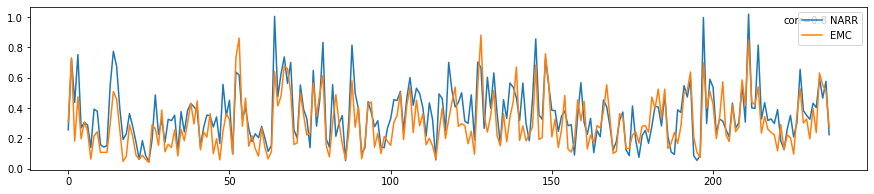

In [57]:
# quick comparison for weekly averages
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(111)
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']))
plt.plot(week1lr.mean(dim='Mll').pr/8) 
plt.legend(('NARR','EMC'))
plt.text(0.9,0.9,
         'corr='+np.str(np.round(np.corrcoef(ds_NARRpr_T.apcp.mean(dim=['lat','lon']),week1lr.mean(dim='Mll').pr/8)[0,1],
                  2, )),transform=ax.transAxes)

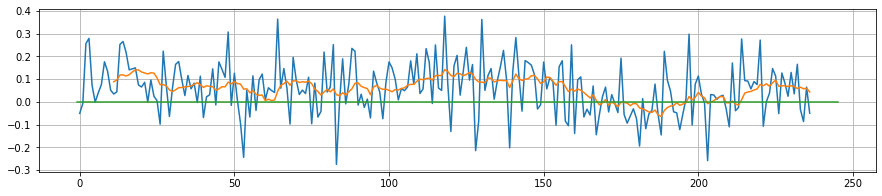

In [58]:
# calculate differences and a rolling mean.
fig = plt.figure(figsize=(15,3))

differences = (ds_NARRpr_T.apcp.mean(dim=['lat','lon']))-(week1lr.mean(dim='Mll').pr/8)
plt.plot(differences)
plt.plot((differences.rolling(T=12).mean().values))

plt.plot([-1,245],[0,0])
plt.grid()

Text(0, 0.5, 'EMC')

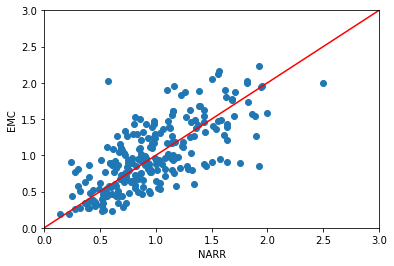

In [59]:
# compare quantiles over the area
plt.plot(ds_NARRpr_T.apcp.quantile(q=0.95,dim=['lat','lon']),
         week1lr.quantile(q=0.95,dim='Mll').pr/8,'o') 
plt.xlim((0,3))
plt.ylim((0,3))
plt.plot([0,3],[0,3],'r-')
plt.xlabel('NARR')
plt.ylabel('EMC')

Text(0, 0.5, 'EMC')

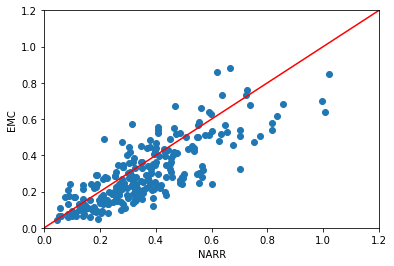

In [60]:
# calculate the mean over the investigated area.
plt.plot(ds_NARRpr_T.apcp.mean(dim=['lat','lon']),week1lr.mean(dim='Mll').pr/8,'o') 
plt.xlim((0,1.2))
plt.ylim((0,1.2))
plt.plot([0,1.5],[0,1.5],'r-')
plt.xlabel('NARR')
plt.ylabel('EMC')

# Save the data for next step

In [61]:
week1lr

<xarray.Dataset>
Dimensions:  (Mll: 1694, T: 237)
Coordinates:
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * Mll      (Mll) MultiIndex
  - M        (Mll) int64 0 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 10 10 10
  - lat      (Mll) float64 42.0 42.0 42.0 42.0 42.0 ... 32.0 32.0 32.0 32.0 32.0
  - lon      (Mll) float64 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
  * T        (T) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    pr       (T, Mll) float32 2.6285713 0.90000004 ... 0.47142857 0.12857142
    tas      (T, Mll) float32 295.0 295.32858 296.80002 ... 301.36285 300.89572
    tdps     (T, Mll) float32 276.97144 277.64285 ... 292.5957 291.56143
    cape     (T, Mll) float32 150.42857 337.57144 480.2857 ... 332.0 211.14285

In [62]:
ds_NARRpr_T

<xarray.Dataset>
Dimensions:  (T: 237, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float32 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * T        (T) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
Data variables:
    apcp     (T, lat, lon) float32 0.037341055 0.17766069 ... 0.39427418
Attributes:
    Conventions:  IRIDL

In [63]:
week1lr = week1lr.unstack()

In [64]:
ds_merged = xr.merge([ds_NARRpr_T ,week1lr])
ds_merged

<xarray.Dataset>
Dimensions:  (M: 11, T: 237, lat: 11, lon: 14)
Coordinates:
  * lat      (lat) float64 32.0 33.0 34.0 35.0 36.0 ... 38.0 39.0 40.0 41.0 42.0
  * lon      (lon) float32 257.0 258.0 259.0 260.0 ... 267.0 268.0 269.0 270.0
    S        (T) datetime64[ns] 1999-06-02 1999-06-09 ... 2016-08-24 2016-08-31
  * T        (T) datetime64[ns] 1999-06-03T12:00:00 ... 2016-09-01T12:00:00
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    apcp     (T, lat, lon) float32 0.037341055 0.17766069 ... 0.39427418
    pr       (T, M, lat, lon) float32 0.31428573 0.5285714 ... 9.927142 7.697143
    tas      (T, M, lat, lon) float32 303.21432 303.01425 ... 294.82858
    tdps     (T, M, lat, lon) float32 279.32858 285.18573 ... 289.33572 288.5671
    cape     (T, M, lat, lon) float32 366.57144 544.4286 ... 371.7143 251.57143

# Note how apcp is of course missing the M dimension (ensemble member)

In [66]:
ds_merged.to_netcdf('ds_merged_EMC_allMB.nc')

# we could broadcast NARR dimensions (T, lat, lon) to (T,M,lat,lon), but we won't do it now, I don't think we need it.
